Training Baseline Model : Linear Regression from scikit-learn

In [111]:
# install dependencies
# %pip install pandas scikit-learn timm matplotlib
# %pip install ipywidgets
# %pip install seaborn

In [112]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import time
import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

In [113]:
class YoutubeDataset(Dataset):
    def __init__(self, data, doc2vec):
        self.ids = list(data['video_id'])
        self.titles = doc2vec # pretrained doc2vec features
        self.data = data # video_id, metadata, views(y) from csv file
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # index order of video_id, meta, y are same
        video_id = self.ids[idx]
        
        image = Image.open('/mnt/medium_15287/{}.jpg'.format(video_id)) # load image
        image = self.transform(image)
        image = image.to(self.device)
        
        title = self.titles[video_id] # get video title
        title = torch.FloatTensor(np.array(title, dtype=np.float16))
        
        meta = torch.FloatTensor(self.data[['period_day', 'subscriber_count']].to_numpy()[idx]) # get metadata
        
        y = np.log10(self.data['views'].to_numpy() + 1) # add 1 for zero views
        y = np.expand_dims(y, axis=1) # add batch dimension
        y = torch.FloatTensor(y[idx]) # get log10(views+1) by idx value
        
        return video_id, image, title, meta, y

In [114]:
class Model(nn.Module):
    def __init__(self, use_image=True):
        super(Model, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.fc1 = nn.Linear(172812, 1) # using image
        self.fc2 = nn.Linear(12, 1) # not using image
        self.use_image = use_image
    
    def forward(self, feature_map, title, meta):
        if self.use_image:
            feature_map, title, meta = feature_map.to(self.device), title.to(self.device), meta.to(self.device)
            feature_map = torch.flatten(feature_map, start_dim=1)
            x = torch.cat([feature_map, title, meta], dim=1)
            x = self.fc1(x)
            return x
        else:
            title, meta = title.to(self.device), meta.to(self.device)
            x = torch.cat([title, meta], dim=1)
            x = self.fc2(x)
            return x

    def train_(self, epochs, lr, train_loader, valid_loader, save_every):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        def positive_view_loss(x):
            zero_tensor = torch.zeros_like(x)
            pv_loss = torch.square(torch.maximum(zero_tensor, -x))
            return pv_loss.mean()

        self.train_loss_log = []
        self.train_mse_log = []
        self.valid_mse_log = []

        best_mse = 1e100
        best_epoch = 1

        train_start = time.time()

        print("Model will be trained on {}\n".format(self.device))

        for epoch in range(1, epochs + 1):
            self.train()
            print("[Epoch {:3d} / {}]".format(epoch, epochs))

            epoch_start = time.time()
            epoch_loss = 0.0
            epoch_mse = 0.0
            
            #training
            for batch_idx, batch_data in enumerate(tqdm(train_loader, desc="Training")):
                batch_video_id, batch_image, batch_title, batch_meta, batch_target = batch_data
                batch_target = batch_target.to(self.device)
                
                self.optimizer.zero_grad()
                output = self.forward(batch_image, batch_title, batch_meta)
                mse_loss = self.criterion(output, batch_target)
                loss = mse_loss
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                epoch_mse += mse_loss.item()

                # print('Epoch : {}, mini-batch : {}, loss : {}'.format(epoch, batch_idx, loss.item()))

            epoch_end = time.time()
            m, s = divmod(epoch_end - epoch_start, 60)
            
            epoch_loss /= len(train_loader)
            epoch_mse /= len(train_loader)
            self.train_loss_log.append(epoch_loss)
            self.train_mse_log.append(epoch_mse)
            
            #validation
            with torch.no_grad():
                self.eval()
                true_y, pred_y = self.predict(valid_loader)                
                true_y = torch.FloatTensor(true_y)
                pred_y = torch.FloatTensor(pred_y)
                valid_mse = self.criterion(pred_y, true_y)
                self.valid_mse_log.append(valid_mse.item())

            print("Train MSE = {:.4f} | Valid MSE = {:.4f}".format(epoch_mse, valid_mse))
            print(f"Train Time: {m:.0f}m {s:.0f}s\n")

            valid_mse = valid_mse.item()
            if best_mse > valid_mse:
                print("=> Best Model Updated : Epoch = {}, Valid MSE = {:.4f}\n".format(epoch, valid_mse))
                best_mse = valid_mse
                best_epoch = epoch
                torch.save(self.state_dict(), "./best_model/best_model.pt")
            else:
                print()

            # save model for every ? epoch
            if (epoch % save_every) == 0:
                torch.save(self.state_dict(),"./model/epoch{}_train-mse{:.4f}_valid-mse{:.4f}.pt".format(epoch, epoch_mse, valid_mse))

        m, s = divmod(time.time() - train_start, 60)
        print("\nTraining Finished...!!")
        print("\nBest Valid MSE : %.2f at epoch %d" % (best_mse, best_epoch))
        print(f"Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {self.device}!")

        torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))
    
    def restore(self):
        with open("./best_model/best_model.pt", "rb") as f:
            state_dict = torch.load(f)
        self.load_state_dict(state_dict)

    def predict(self, dataloader):
        with torch.no_grad():
            self.eval()
            true_y = []
            pred_y = []
            for batch_video_id, batch_image, batch_title, batch_meta, batch_target in dataloader:
                pred = self.forward(batch_image, batch_title, batch_meta)
                true_y.append(batch_target.numpy())
                pred_y.append(pred.cpu().numpy())
            pred_y = np.concatenate(pred_y, axis=0)
            true_y = np.concatenate(true_y, axis=0)
        return pred_y, true_y #numpy array

    def plot(self, start=0, step=1):
        plt.figure(1)
        plt.plot(np.array(self.train_mse_log[start::step]), "b", label='Train MSE')
        plt.plot(np.array(self.valid_mse_log[start::step]), "r", label='Valid Mse')
        plt.legend()
        plt.title('MSE')
        plt.savefig("./mse-graph.png")
        
        plt.figure(2)
        plt.plot(np.array(self.train_loss_log[start::step]), "g", label='Train Loss')
        plt.legend()
        plt.title('Train Loss')
        plt.savefig("./loss-graph.png")
        
        plt.show()


In [115]:
%cd /mnt

/mnt


In [116]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

Train Data Statistics before Normalization
mean period :  335.83891836883043
std period :  497.77141615927457
mean subscriber :  1784439.962419132
std subscriber :  3833901.649291374


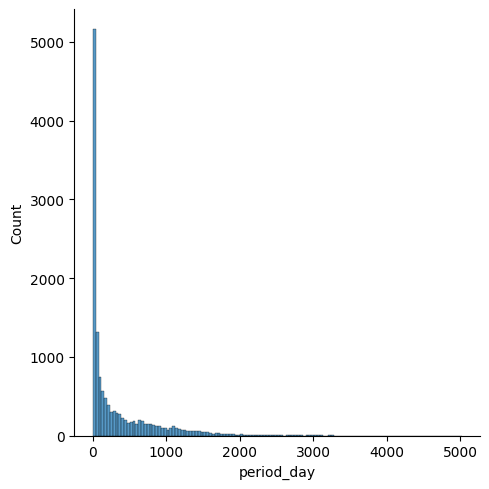

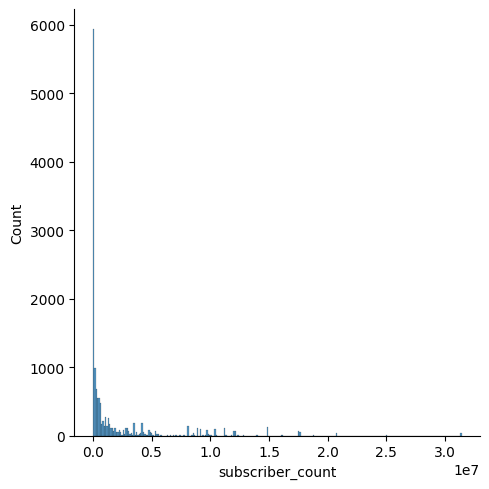

In [117]:
# before normalization
sns.displot(train_data["period_day"])
sns.displot(train_data["subscriber_count"])

mean_period = train_data['period_day'].mean()
std_period = train_data['period_day'].std()
mean_subscriber = train_data['subscriber_count'].mean()
std_subscriber = train_data['subscriber_count'].std()

print('Train Data Statistics before Normalization')
print("mean period : ", mean_period)
print("std period : ", std_period)
print("mean subscriber : ", mean_subscriber)
print("std subscriber : ", std_subscriber)

In [118]:
# train data nomarlization
train_data['period_day'] = (train_data['period_day'] - mean_period) / std_period
train_data['subscriber_count'] = (train_data['subscriber_count'] - mean_subscriber) / std_subscriber

# test data nomarlization
test_data['period_day'] = (test_data['period_day'] - mean_period) / std_period
test_data['subscriber_count'] = (test_data['subscriber_count'] - mean_subscriber) / std_subscriber

Train Data Statistics after Normalization
mean period :  -5.784748593816327e-17
std period :  1.0
mean subscriber :  2.685776132843295e-17
std subscriber :  1.0


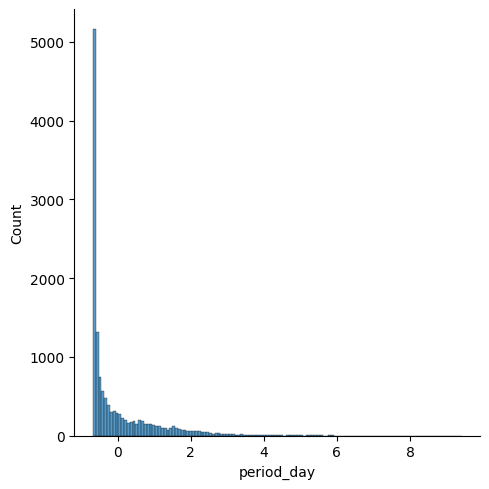

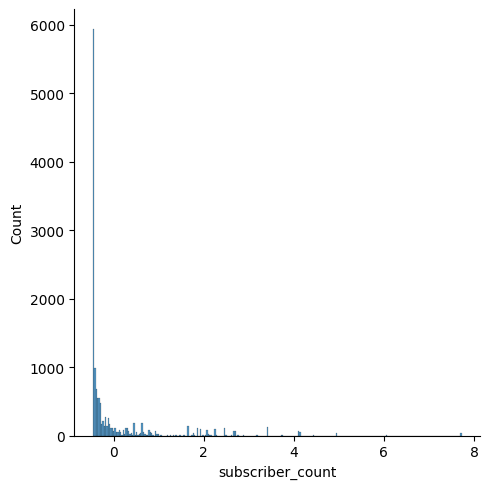

In [119]:
# after normalization
sns.displot(train_data["period_day"])
sns.displot(train_data["subscriber_count"])

mean_period = train_data['period_day'].mean()
std_period = train_data['period_day'].std()
mean_subscriber = train_data['subscriber_count'].mean()
std_subscriber = train_data['subscriber_count'].std()

print('Train Data Statistics after Normalization')
print("mean period : ", mean_period)
print("std period : ", std_period)
print("mean subscriber : ", mean_subscriber)
print("std subscriber : ", std_subscriber)

In [120]:
# split train -> train : valid = 9 : 1
train_data, valid_data = train_test_split(train_data, test_size = 0.1, random_state = 55)
print('Train Dataset Size : ',len(train_data))
print('Validation Dataset Size : ',len(valid_data))
print('Test Dataset Size : ',len(test_data))

Train Dataset Size :  12381
Validation Dataset Size :  1376
Test Dataset Size :  1529


In [121]:
# open doc2vec data and convert to dict
with open('./title_doc2vec_10', 'rb') as f:
    doc2vec = pickle.load(f)

data_dict=dict()
for row in doc2vec:
    vid=row[0]
    vec=row[1:]
    data_dict[vid]=vec

doc2vec = data_dict
print(len(doc2vec))

15287


In [122]:
#setting hyper parameters
batch_size = 64
epochs = 50
lr = 1e-5
save_every = 5

In [123]:
train_dataset = YoutubeDataset(train_data, doc2vec)
valid_dataset = YoutubeDataset(valid_data, doc2vec)
test_dataset = YoutubeDataset(test_data, doc2vec)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [124]:
model = Model(use_image=False)
model.to(model.device)
model.train_(epochs, lr, train_loader, valid_loader, save_every)

Model will be trained on cuda

[Epoch   1 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 29.7007 | Valid MSE = 30.2650
Train Time: 1m 27s

=> Best Model Updated : Epoch = 1, Valid MSE = 30.2650

[Epoch   2 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 29.4977 | Valid MSE = 30.0445
Train Time: 1m 27s

=> Best Model Updated : Epoch = 2, Valid MSE = 30.0445

[Epoch   3 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 29.2779 | Valid MSE = 29.8271
Train Time: 1m 27s

=> Best Model Updated : Epoch = 3, Valid MSE = 29.8271

[Epoch   4 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 29.0704 | Valid MSE = 29.6116
Train Time: 1m 25s

=> Best Model Updated : Epoch = 4, Valid MSE = 29.6116

[Epoch   5 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 28.8484 | Valid MSE = 29.4001
Train Time: 1m 27s

=> Best Model Updated : Epoch = 5, Valid MSE = 29.4001

[Epoch   6 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 28.6475 | Valid MSE = 29.1900
Train Time: 1m 26s

=> Best Model Updated : Epoch = 6, Valid MSE = 29.1900

[Epoch   7 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 28.4458 | Valid MSE = 28.9817
Train Time: 1m 27s

=> Best Model Updated : Epoch = 7, Valid MSE = 28.9817

[Epoch   8 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 28.2452 | Valid MSE = 28.7761
Train Time: 1m 27s

=> Best Model Updated : Epoch = 8, Valid MSE = 28.7761

[Epoch   9 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 28.0468 | Valid MSE = 28.5724
Train Time: 1m 28s

=> Best Model Updated : Epoch = 9, Valid MSE = 28.5724

[Epoch  10 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 27.8613 | Valid MSE = 28.3721
Train Time: 1m 27s

=> Best Model Updated : Epoch = 10, Valid MSE = 28.3721

[Epoch  11 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 27.6717 | Valid MSE = 28.1720
Train Time: 1m 27s

=> Best Model Updated : Epoch = 11, Valid MSE = 28.1720

[Epoch  12 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 27.5011 | Valid MSE = 27.9745
Train Time: 1m 27s

=> Best Model Updated : Epoch = 12, Valid MSE = 27.9745

[Epoch  13 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 27.2898 | Valid MSE = 27.7781
Train Time: 1m 27s

=> Best Model Updated : Epoch = 13, Valid MSE = 27.7781

[Epoch  14 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 27.1152 | Valid MSE = 27.5848
Train Time: 1m 27s

=> Best Model Updated : Epoch = 14, Valid MSE = 27.5848

[Epoch  15 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 26.9064 | Valid MSE = 27.3926
Train Time: 1m 26s

=> Best Model Updated : Epoch = 15, Valid MSE = 27.3926

[Epoch  16 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 26.7338 | Valid MSE = 27.2033
Train Time: 1m 27s

=> Best Model Updated : Epoch = 16, Valid MSE = 27.2033

[Epoch  17 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 26.5611 | Valid MSE = 27.0147
Train Time: 1m 28s

=> Best Model Updated : Epoch = 17, Valid MSE = 27.0147

[Epoch  18 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 26.3868 | Valid MSE = 26.8280
Train Time: 1m 26s

=> Best Model Updated : Epoch = 18, Valid MSE = 26.8280

[Epoch  19 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 26.1995 | Valid MSE = 26.6430
Train Time: 1m 27s

=> Best Model Updated : Epoch = 19, Valid MSE = 26.6430

[Epoch  20 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 26.0242 | Valid MSE = 26.4603
Train Time: 1m 27s

=> Best Model Updated : Epoch = 20, Valid MSE = 26.4603

[Epoch  21 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 25.8522 | Valid MSE = 26.2783
Train Time: 1m 27s

=> Best Model Updated : Epoch = 21, Valid MSE = 26.2783

[Epoch  22 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 25.6709 | Valid MSE = 26.0982
Train Time: 1m 27s

=> Best Model Updated : Epoch = 22, Valid MSE = 26.0982

[Epoch  23 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 25.4953 | Valid MSE = 25.9204
Train Time: 1m 27s

=> Best Model Updated : Epoch = 23, Valid MSE = 25.9204

[Epoch  24 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 25.3434 | Valid MSE = 25.7430
Train Time: 1m 27s

=> Best Model Updated : Epoch = 24, Valid MSE = 25.7430

[Epoch  25 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 25.1817 | Valid MSE = 25.5686
Train Time: 1m 27s

=> Best Model Updated : Epoch = 25, Valid MSE = 25.5686

[Epoch  26 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 24.9958 | Valid MSE = 25.3951
Train Time: 1m 27s

=> Best Model Updated : Epoch = 26, Valid MSE = 25.3951

[Epoch  27 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 24.8700 | Valid MSE = 25.2244
Train Time: 1m 27s

=> Best Model Updated : Epoch = 27, Valid MSE = 25.2244

[Epoch  28 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 24.6816 | Valid MSE = 25.0525
Train Time: 1m 27s

=> Best Model Updated : Epoch = 28, Valid MSE = 25.0525

[Epoch  29 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 24.5025 | Valid MSE = 24.8850
Train Time: 1m 26s

=> Best Model Updated : Epoch = 29, Valid MSE = 24.8850

[Epoch  30 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 24.3412 | Valid MSE = 24.7179
Train Time: 1m 26s

=> Best Model Updated : Epoch = 30, Valid MSE = 24.7179

[Epoch  31 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 24.1869 | Valid MSE = 24.5524
Train Time: 1m 27s

=> Best Model Updated : Epoch = 31, Valid MSE = 24.5524

[Epoch  32 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 24.0315 | Valid MSE = 24.3885
Train Time: 1m 27s

=> Best Model Updated : Epoch = 32, Valid MSE = 24.3885

[Epoch  33 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 23.8763 | Valid MSE = 24.2261
Train Time: 1m 27s

=> Best Model Updated : Epoch = 33, Valid MSE = 24.2261

[Epoch  34 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 23.7208 | Valid MSE = 24.0648
Train Time: 1m 27s

=> Best Model Updated : Epoch = 34, Valid MSE = 24.0648

[Epoch  35 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 23.5712 | Valid MSE = 23.9054
Train Time: 1m 27s

=> Best Model Updated : Epoch = 35, Valid MSE = 23.9054

[Epoch  36 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 23.4160 | Valid MSE = 23.7477
Train Time: 1m 27s

=> Best Model Updated : Epoch = 36, Valid MSE = 23.7477

[Epoch  37 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 23.2675 | Valid MSE = 23.5907
Train Time: 1m 27s

=> Best Model Updated : Epoch = 37, Valid MSE = 23.5907

[Epoch  38 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 23.1328 | Valid MSE = 23.4361
Train Time: 1m 27s

=> Best Model Updated : Epoch = 38, Valid MSE = 23.4361

[Epoch  39 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 22.9787 | Valid MSE = 23.2823
Train Time: 1m 27s

=> Best Model Updated : Epoch = 39, Valid MSE = 23.2823

[Epoch  40 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 22.8297 | Valid MSE = 23.1300
Train Time: 1m 27s

=> Best Model Updated : Epoch = 40, Valid MSE = 23.1300

[Epoch  41 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 22.6916 | Valid MSE = 22.9799
Train Time: 1m 27s

=> Best Model Updated : Epoch = 41, Valid MSE = 22.9799

[Epoch  42 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 22.5369 | Valid MSE = 22.8305
Train Time: 1m 26s

=> Best Model Updated : Epoch = 42, Valid MSE = 22.8305

[Epoch  43 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 22.3923 | Valid MSE = 22.6824
Train Time: 1m 27s

=> Best Model Updated : Epoch = 43, Valid MSE = 22.6824

[Epoch  44 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 22.2567 | Valid MSE = 22.5360
Train Time: 1m 27s

=> Best Model Updated : Epoch = 44, Valid MSE = 22.5360

[Epoch  45 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 22.1181 | Valid MSE = 22.3911
Train Time: 1m 27s

=> Best Model Updated : Epoch = 45, Valid MSE = 22.3911

[Epoch  46 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 21.9702 | Valid MSE = 22.2472
Train Time: 1m 27s

=> Best Model Updated : Epoch = 46, Valid MSE = 22.2472

[Epoch  47 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 21.8298 | Valid MSE = 22.1049
Train Time: 1m 26s

=> Best Model Updated : Epoch = 47, Valid MSE = 22.1049

[Epoch  48 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 21.7053 | Valid MSE = 21.9643
Train Time: 1m 26s

=> Best Model Updated : Epoch = 48, Valid MSE = 21.9643

[Epoch  49 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 21.5563 | Valid MSE = 21.8239
Train Time: 1m 26s

=> Best Model Updated : Epoch = 49, Valid MSE = 21.8239

[Epoch  50 / 50]


Training:   0%|          | 0/194 [00:00<?, ?it/s]

Train MSE = 21.4393 | Valid MSE = 21.6854
Train Time: 1m 26s

=> Best Model Updated : Epoch = 50, Valid MSE = 21.6854


Training Finished...!!

Best Valid MSE : 21.69 at epoch 50
Total Time: 79m 50s
Model was trained on cuda!


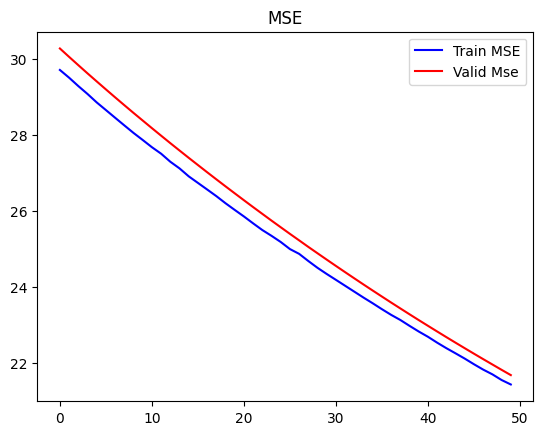

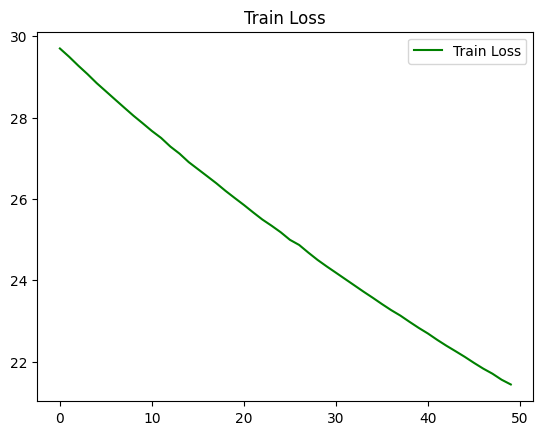

In [125]:
model.plot()

In [126]:
# test
model.restore() # load best model during training
pred_y, true_y = model.predict(test_loader)
true_y = torch.FloatTensor(true_y)
pred_y = torch.FloatTensor(pred_y)
test_mse = model.criterion(pred_y, true_y)
print('Test MSE : ',test_mse.item())

Test MSE :  17.442346572875977
